# MindLens-AI — 01: Exploratory Data Analysis

Analyze the Reddit Depression dataset to understand class distribution, text characteristics, and key patterns before model training.

In [1]:
# Setup
import sys, os
sys.path.insert(0, os.path.abspath(".."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from src.preprocessing import (
    load_primary_dataset,
    preprocess_pipeline,
    save_processed,
)
from src.features import build_tfidf

# Style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

print("Setup complete ✓")

Setup complete ✓


## 1. Load & Preprocess Data

In [2]:
# Load raw dataset
raw_df = load_primary_dataset("../data/raw/depression_dataset_reddit_cleaned.csv")
print(f"Raw dataset: {raw_df.shape[0]} rows, {raw_df.shape[1]} cols")
print(raw_df["label"].value_counts())

# Preprocess
df = preprocess_pipeline(raw_df, remove_stopwords=False)
print(f"\nProcessed dataset: {df.shape[0]} rows")
df.head()

Raw dataset: 7731 rows, 2 cols
label
0    3900
1    3831
Name: count, dtype: int64

Processed dataset: 7648 rows


,text,label,word_count,char_count,avg_word_length,word_density,unique_word_ratio
0,we understand that most people who reply immed...,1,810,4527,5.588889,0.178926,0.433333
1,welcome to r depression s check in post a plac...,1,427,2389,5.594848,0.178736,0.473068
2,anyone else instead of sleeping more when depr...,1,45,236,5.244444,0.190678,0.866667
3,i ve kind of stuffed around a lot in my life d...,1,109,508,4.660550,0.214567,0.678899
4,sleep is my greatest and most comforting escap...,1,54,281,5.203704,0.192171,0.814815


## 2. Dataset Overview

In [3]:
print("Shape:", df.shape)
print("\n--- Info ---")
df.info()
print("\n--- Describe ---")
df.describe()

Shape: (7648, 7)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7648 entries, 0 to 7647
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               7648 non-null   object 
 1   label              7648 non-null   int32  
 2   word_count         7648 non-null   int64  
 3   char_count         7648 non-null   int64  
 4   avg_word_length    7648 non-null   float64
 5   word_density       7648 non-null   float64
 6   unique_word_ratio  7648 non-null   float64
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 388.5+ KB

--- Describe ---


,label,word_count,char_count,avg_word_length,word_density,unique_word_ratio
count,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000,7648.000000
mean,0.491501,73.916449,358.083290,5.014424,0.203707,0.840120
std,0.499960,142.101446,685.022182,0.931683,0.027758,0.174763
min,0.000000,1.000000,3.000000,2.000000,0.020408,0.226050
25%,0.000000,12.000000,58.000000,4.578947,0.189655,0.711111
50%,0.000000,22.000000,109.000000,4.863636,0.205607,0.906250
75%,1.000000,76.000000,362.000000,5.272727,0.218391,1.000000
max,1.000000,4238.000000,19820.000000,49.000000,0.500000,1.000000


## 3. Class Distribution

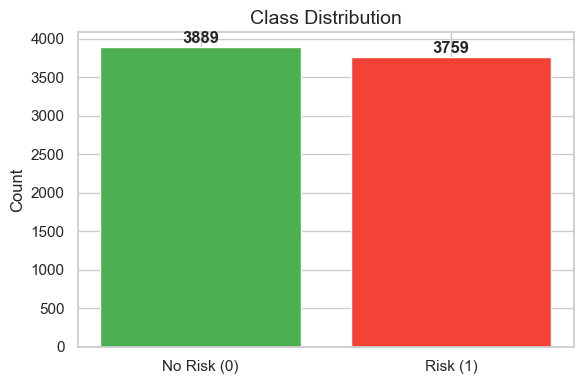

Class balance — 0: 3889 (50.8%)  1: 3759 (49.2%)


In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
counts = df["label"].value_counts().sort_index()
bars = ax.bar(["No Risk (0)", "Risk (1)"], counts.values, color=["#4CAF50", "#F44336"])
for bar, val in zip(bars, counts.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            str(val), ha="center", fontweight="bold")
ax.set_title("Class Distribution", fontsize=14)
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

print(f"Class balance — 0: {counts[0]} ({counts[0]/len(df)*100:.1f}%)  "
      f"1: {counts[1]} ({counts[1]/len(df)*100:.1f}%)")

## 4. Text Length Analysis

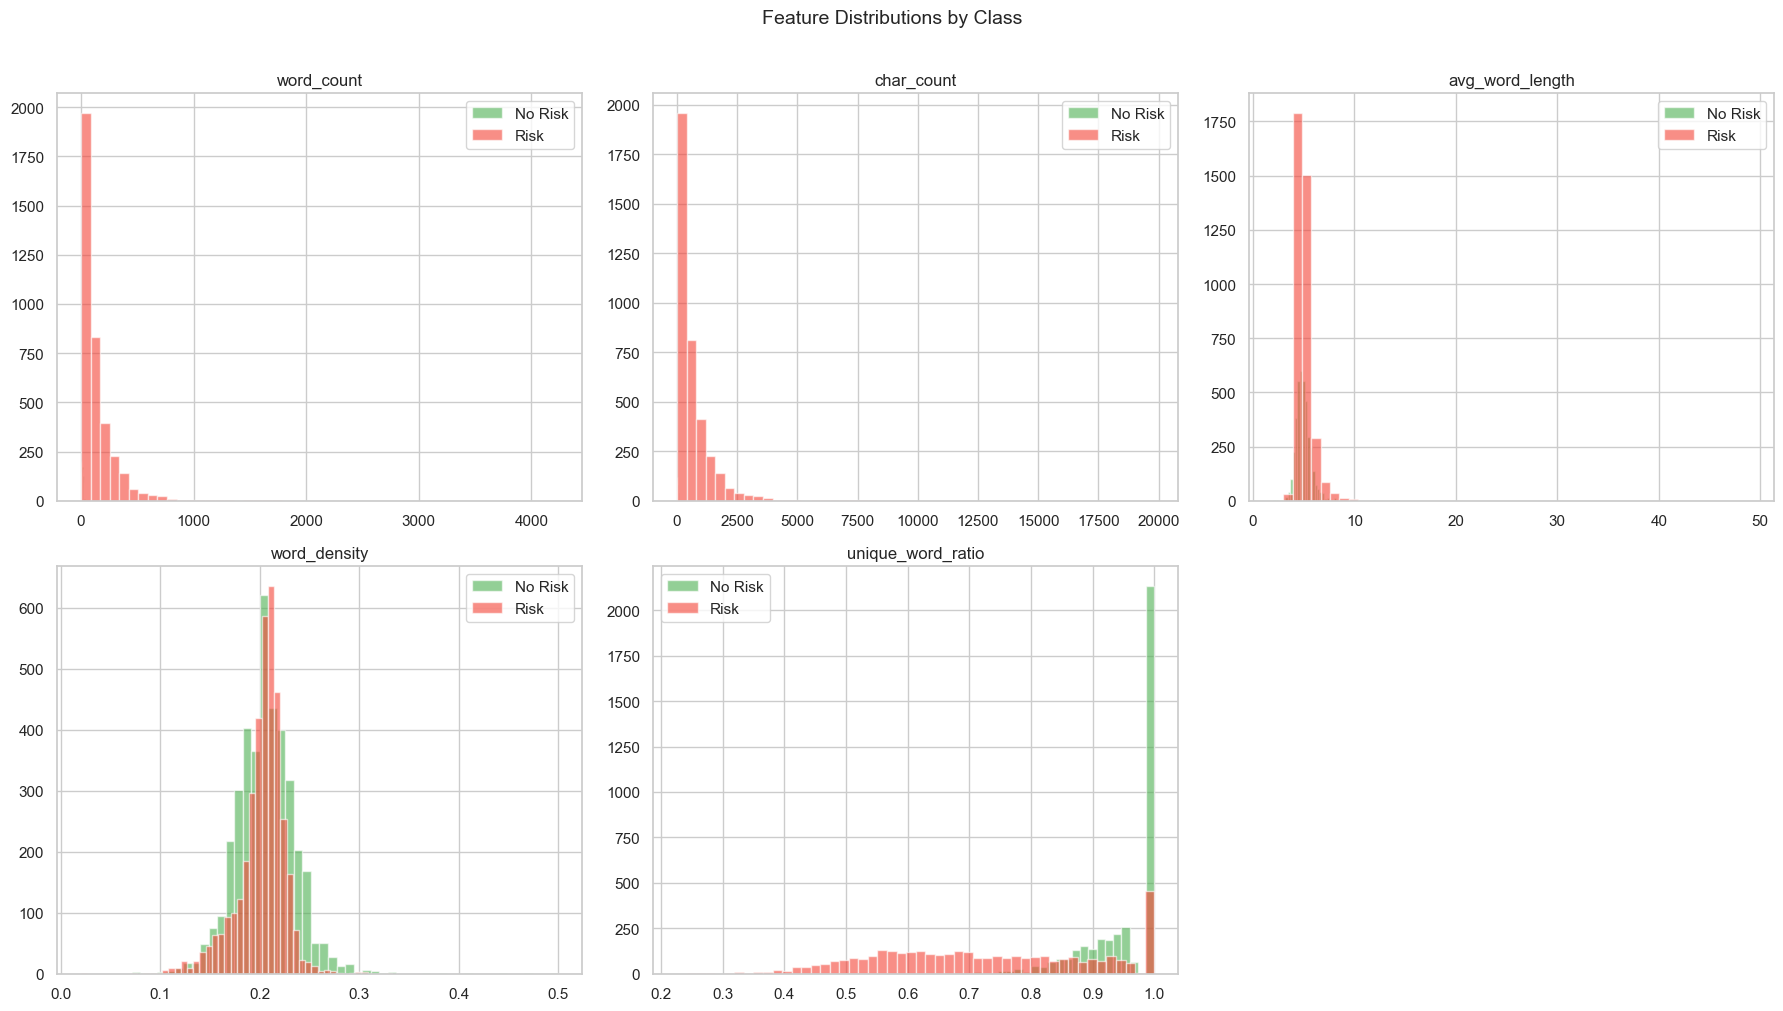

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ["word_count", "char_count", "avg_word_length", "word_density", "unique_word_ratio"]
labels_map = {0: "No Risk", 1: "Risk"}
colors = {0: "#4CAF50", 1: "#F44336"}

for i, feat in enumerate(features):
    ax = axes[i // 3][i % 3]
    for lab in [0, 1]:
        subset = df[df["label"] == lab][feat]
        ax.hist(subset, bins=50, alpha=0.6, label=labels_map[lab], color=colors[lab])
    ax.set_title(feat, fontsize=12)
    ax.legend()

# Remove empty subplot
axes[1][2].set_visible(False)
plt.suptitle("Feature Distributions by Class", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## 5. Word Clouds

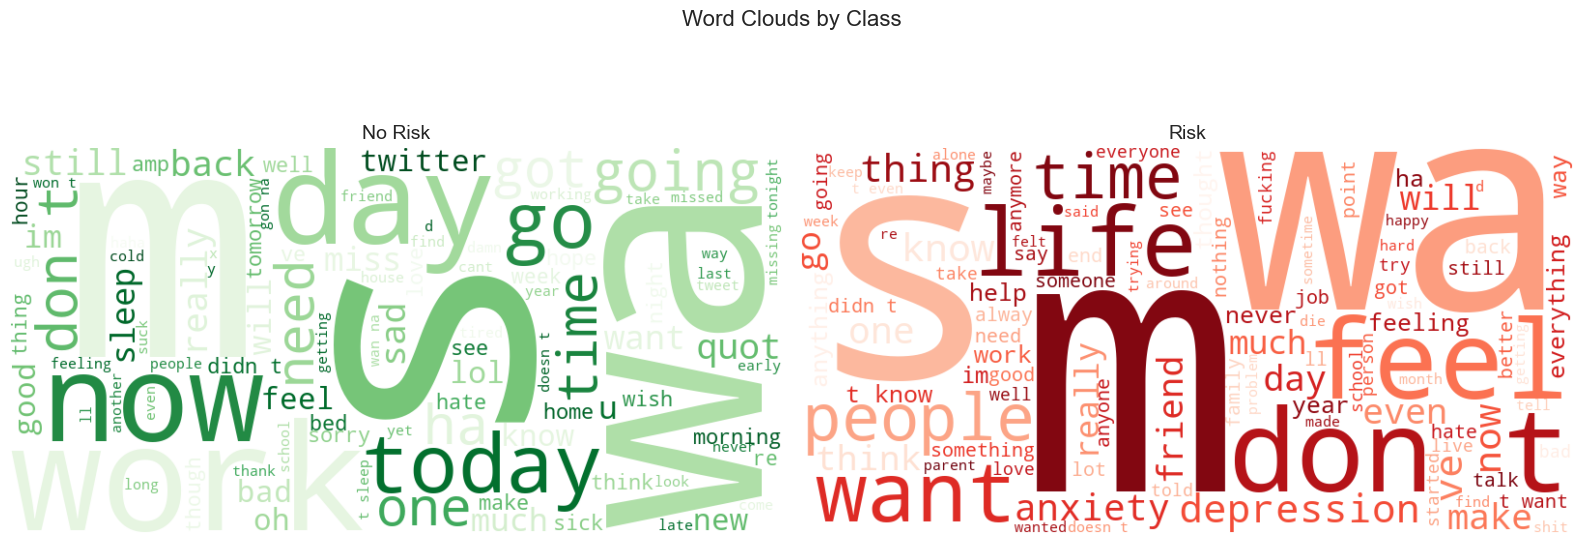

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (lab, title, cmap) in enumerate([(0, "No Risk", "Greens"), (1, "Risk", "Reds")]):
    text_blob = " ".join(df[df["label"] == lab]["text"].dropna())
    wc = WordCloud(width=800, height=400, background_color="white",
                   colormap=cmap, max_words=100).generate(text_blob)
    axes[idx].imshow(wc, interpolation="bilinear")
    axes[idx].set_title(title, fontsize=14)
    axes[idx].axis("off")

plt.suptitle("Word Clouds by Class", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## 6. Top TF-IDF Terms per Class

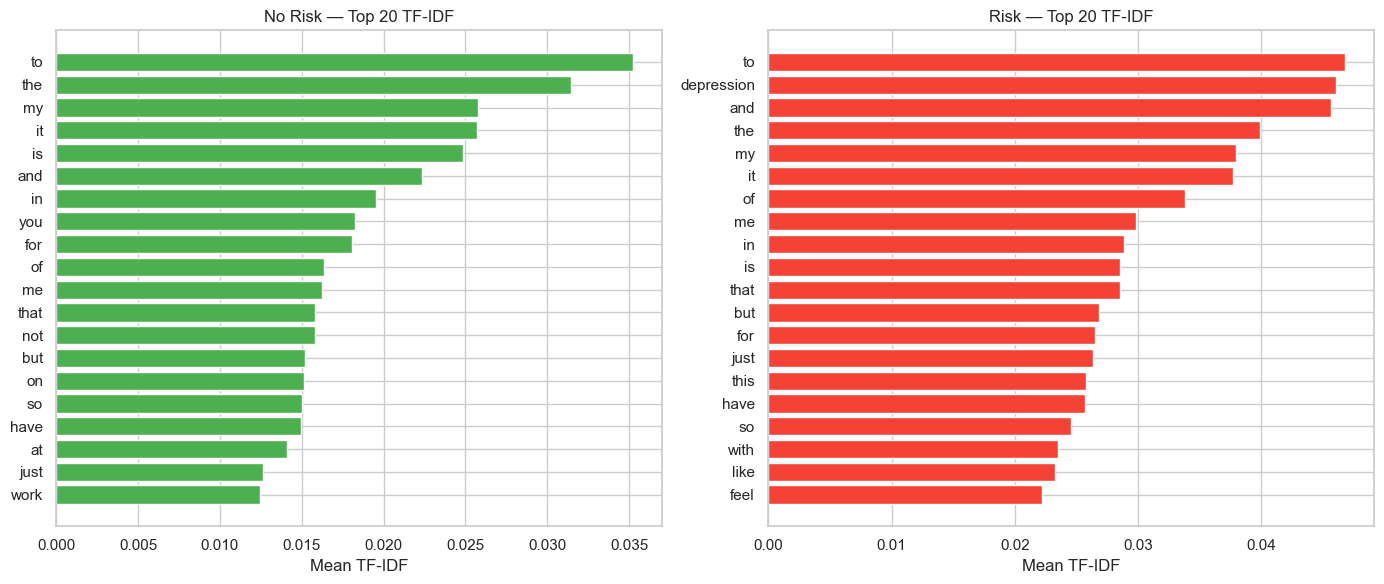

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, (lab, title, color) in enumerate([(0, "No Risk — Top 20 TF-IDF", "#4CAF50"),
                                            (1, "Risk — Top 20 TF-IDF", "#F44336")]):
    subset_texts = df[df["label"] == lab]["text"]
    vec, X = build_tfidf(subset_texts, max_features=5000)
    mean_tfidf = X.mean(axis=0).A1
    top_idx = mean_tfidf.argsort()[-20:]
    words = np.array(vec.get_feature_names_out())[top_idx]
    scores = mean_tfidf[top_idx]

    axes[idx].barh(words, scores, color=color)
    axes[idx].set_title(title, fontsize=12)
    axes[idx].set_xlabel("Mean TF-IDF")

plt.tight_layout()
plt.show()

## 7. Feature Correlations

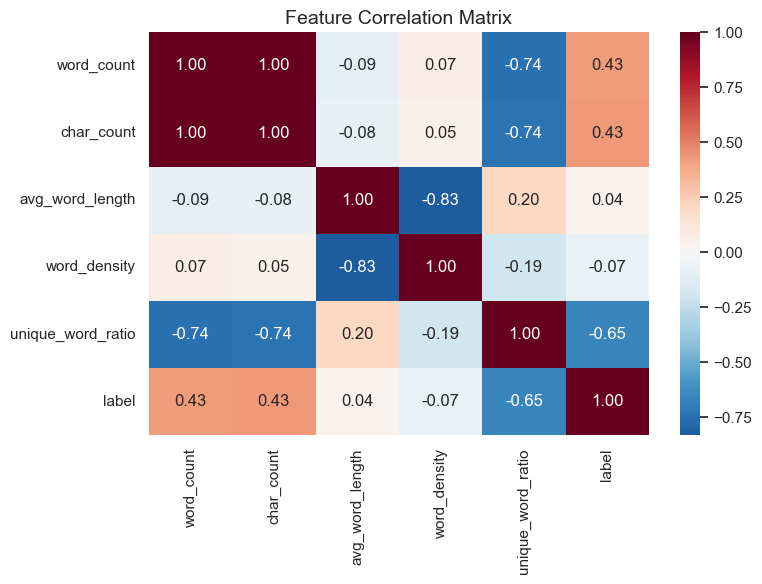

In [8]:
numeric_cols = ["word_count", "char_count", "avg_word_length", "word_density", "unique_word_ratio", "label"]
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0, ax=ax)
ax.set_title("Feature Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## 8. Summary Statistics by Class

In [9]:
summary = df.groupby("label")[["word_count", "char_count", "avg_word_length",
                               "word_density", "unique_word_ratio"]].agg(["mean", "median", "std"])
summary.columns = ["_".join(c) for c in summary.columns]
summary

,word_count_mean,word_count_median,word_count_std,char_count_mean,char_count_median,char_count_std,avg_word_length_mean,avg_word_length_median,avg_word_length_std,word_density_mean,word_density_median,word_density_std,unique_word_ratio_mean,unique_word_ratio_median,unique_word_ratio_std
label,,,,,,,,,,,,,,,
0,14.248907,13.0,7.228791,69.605554,66.0,34.464454,4.980205,4.882353,0.814920,0.205501,0.204819,0.030808,0.952406,1.000000,0.066338
1,135.647513,79.0,183.137709,656.537643,373.0,882.281474,5.049826,4.852713,1.037685,0.201851,0.206070,0.024065,0.723950,0.709302,0.176208


## 9. Save Processed Data

In [10]:
save_processed(df, "../data/processed/primary_clean.csv")
print("EDA complete ✓")

Saved 7648 rows → ../data/processed/primary_clean.csv
EDA complete ✓
